# Dataset Preprocessing


 # Step 1: Setup & Configuration

In [36]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configuration
CONFIG = {
    'train_file': 'train-2.txt',
    'test_split': 0.2,
    'min_user_interactions': 0,
    'min_item_interactions': 0,
    'random_seed': 42
}

print(" Configuration loaded")
print(f"  Train file: {CONFIG['train_file']}")
print(f"  Validation split: {CONFIG['test_split']*100:.0f}%")
print(f"  Random seed: {CONFIG['random_seed']}")


 Configuration loaded
  Train file: train-2.txt
  Validation split: 20%
  Random seed: 42


#STEP 2: Data Loading

In [37]:
def load_interaction_data(filepath):
    interactions = []

    with open(filepath, 'r') as f:
        for line_num, line in enumerate(f, 1):
            parts = line.strip().split()

            # Skip empty lines
            if len(parts) <= 1:
                continue

            user = parts[0]
            items = parts[1:]

            # Create one row per interaction
            for item in items:
                interactions.append((user, item))

            # Progress update every 10k lines
            if line_num % 10000 == 0:
                print(f"  Processed {line_num:,} users...", end='\r')

    print(f"  Processed {line_num:,} users... Done!      ")

    # Convert to DataFrame
    df = pd.DataFrame(interactions, columns=['user_raw', 'item_raw'])

    return df

# Load data
inter_df = load_interaction_data(CONFIG['train_file'])

print(f"\n Data loaded:")
print(f"  Raw interactions: {len(inter_df):,}")
print(f"  Unique users: {inter_df['user_raw'].nunique():,}")
print(f"  Unique items: {inter_df['item_raw'].nunique():,}")


  Processed 52,644 users... Done!      

 Data loaded:
  Raw interactions: 2,380,730
  Unique users: 52,643
  Unique items: 91,599


# Step 3: Data Quality Check & Cleaning

In [38]:
# Check for nulls
null_count = inter_df.isnull().sum().sum()
print(f"\nNull values: {null_count}")

# Check for duplicates
duplicate_count = inter_df.duplicated().sum()
print(f"Duplicate interactions: {duplicate_count:,} ({100*duplicate_count/len(inter_df):.2f}%)")

# Store original count
original_count = len(inter_df)

# Remove duplicates
if duplicate_count > 0:
    print(f"\nRemoving duplicates...")
    inter_df = inter_df.drop_duplicates()
    print(f"  Before: {original_count:,}")
    print(f"  After: {len(inter_df):,}")
    print(f"  Removed: {duplicate_count:,}")
else:
    print("\n No duplicates found")

print(f"\n Data cleaned:")
print(f"  Final interactions: {len(inter_df):,}")
print(f"  Unique users: {inter_df['user_raw'].nunique():,}")
print(f"  Unique items: {inter_df['item_raw'].nunique():,}")



Null values: 0
Duplicate interactions: 0 (0.00%)

 No duplicates found

 Data cleaned:
  Final interactions: 2,380,730
  Unique users: 52,643
  Unique items: 91,599


# Step 4 : Statistical Analysis


Users:
  Total: 52,643
  Mean interactions: 45.2
  Median: 26

Items:
  Total: 91,599
  Mean interactions: 26.0
  Median: 15


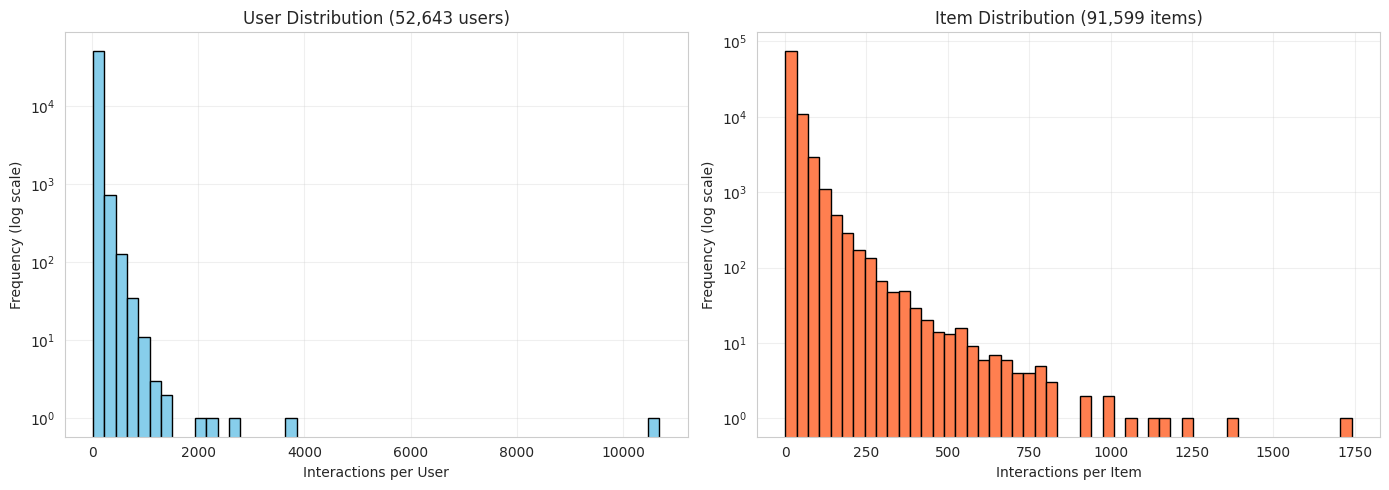


 Visualization saved: preprocessing_distribution.png


In [39]:
user_counts = inter_df["user_raw"].value_counts()
item_counts = inter_df["item_raw"].value_counts()

print(f"\nUsers:")
print(f"  Total: {len(user_counts):,}")
print(f"  Mean interactions: {user_counts.mean():.1f}")
print(f"  Median: {user_counts.median():.0f}")

print(f"\nItems:")
print(f"  Total: {len(item_counts):,}")
print(f"  Mean interactions: {item_counts.mean():.1f}")
print(f"  Median: {item_counts.median():.0f}")

# Simple visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(user_counts, bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Interactions per User')
axes[0].set_ylabel('Frequency (log scale)')
axes[0].set_title(f'User Distribution ({len(user_counts):,} users)')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].hist(item_counts, bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Interactions per Item')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title(f'Item Distribution ({len(item_counts):,} items)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('preprocessing_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: preprocessing_distribution.png")


#Step 5 : Outlier Detection


USERS:
  Normal range: 0 - 84 interactions
  Outliers (>84): 5,526 users (10.5%)

ITEMS:
  Normal range: 0 - 55 interactions
  Outliers (>55): 8,136 items (8.9%)

DECISION: Keep all data (no filtering)
  ✓ Leaderboard needs all users
  ✓ Outliers are real behavior


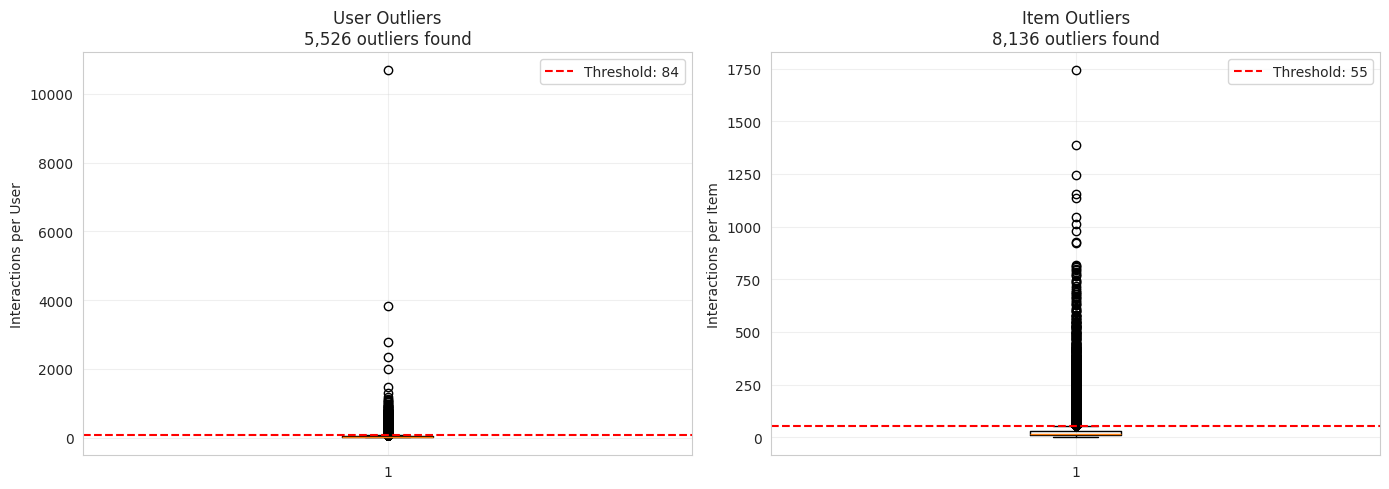


 Saved: outliers.png


In [40]:
# Count interactions per user and item
user_counts = inter_df['user_raw'].value_counts()
item_counts = inter_df['item_raw'].value_counts()

# Calculate quartiles (IQR method)
user_q1 = user_counts.quantile(0.25)
user_q3 = user_counts.quantile(0.75)
user_iqr = user_q3 - user_q1
user_upper = user_q3 + 1.5 * user_iqr

item_q1 = item_counts.quantile(0.25)
item_q3 = item_counts.quantile(0.75)
item_iqr = item_q3 - item_q1
item_upper = item_q3 + 1.5 * item_iqr

# Find outliers
user_outliers = user_counts[user_counts > user_upper]
item_outliers = item_counts[item_counts > item_upper]

# Print results
print(f"\nUSERS:")
print(f"  Normal range: 0 - {user_upper:.0f} interactions")
print(f"  Outliers (>{user_upper:.0f}): {len(user_outliers):,} users ({100*len(user_outliers)/len(user_counts):.1f}%)")

print(f"\nITEMS:")
print(f"  Normal range: 0 - {item_upper:.0f} interactions")
print(f"  Outliers (>{item_upper:.0f}): {len(item_outliers):,} items ({100*len(item_outliers)/len(item_counts):.1f}%)")

print(f"\nDECISION: Keep all data (no filtering)")
print(f"  ✓ Leaderboard needs all users")
print(f"  ✓ Outliers are real behavior")

# Simple visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User boxplot
axes[0].boxplot(user_counts, vert=True)
axes[0].axhline(user_upper, color='red', linestyle='--', label=f'Threshold: {user_upper:.0f}')
axes[0].set_ylabel('Interactions per User')
axes[0].set_title(f'User Outliers\n{len(user_outliers):,} outliers found')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Item boxplot
axes[1].boxplot(item_counts, vert=True)
axes[1].axhline(item_upper, color='red', linestyle='--', label=f'Threshold: {item_upper:.0f}')
axes[1].set_ylabel('Interactions per Item')
axes[1].set_title(f'Item Outliers\n{len(item_outliers):,} outliers found')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outliers.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Saved: outliers.png")


 # Step 6 : Map to Integer IDs

In [41]:
# Get unique entities
unique_users = inter_df["user_raw"].unique()
unique_items = inter_df["item_raw"].unique()

# Create mappings
user2id = {u: i for i, u in enumerate(unique_users)}
item2id = {it: i for i, it in enumerate(unique_items)}

num_users = len(user2id)
num_items = len(item2id)

# Apply mappings
inter_df["user"] = inter_df["user_raw"].map(user2id)
inter_df["item"] = inter_df["item_raw"].map(item2id)

# Reverse mappings (for submission file)
id2user_raw = {v: k for k, v in user2id.items()}
id2item_raw = {v: k for k, v in item2id.items()}

print(f"\n Mapped to integers:")
print(f"  num_users = {num_users:,}")
print(f"  num_items = {num_items:,}")

print("\nSample:")
print(inter_df[["user_raw", "user", "item_raw", "item"]].head())



 Mapped to integers:
  num_users = 52,643
  num_items = 91,599

Sample:
  user_raw  user item_raw  item
0        0     0    28261     0
1        0     0      388     1
2        0     0     5731     2
3        0     0      401     3
4        0     0    28284     4


# Step 7 : Train/Validation Split

In [42]:
# Split
train_df, val_df = train_test_split(
    inter_df[["user", "item"]],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"\n Split complete:")
print(f"  Train: {len(train_df):,} interactions (80%)")
print(f"  Val: {len(val_df):,} interactions (20%)")



 Split complete:
  Train: 1,904,584 interactions (80%)
  Val: 476,146 interactions (20%)


#Step 8 : Build Sparse Matrices

In [43]:
def build_matrix(df, num_users, num_items):
    user_idx = df["user"].values
    item_idx = df["item"].values
    data = np.ones(len(df), dtype=np.float32)

    return sp.csr_matrix(
        (data, (user_idx, item_idx)),
        shape=(num_users, num_items),
        dtype=np.float32
    )

# Build matrices
train_matrix = build_matrix(train_df, num_users, num_items)
val_matrix = build_matrix(val_df, num_users, num_items)
full_matrix = build_matrix(inter_df[["user", "item"]], num_users, num_items)

print(f"\n Matrices created:")
print(f"  Train: {train_matrix.shape}, {train_matrix.nnz:,} non-zero")
print(f"  Val: {val_matrix.shape}, {val_matrix.nnz:,} non-zero")
print(f"  Full: {full_matrix.shape}, {full_matrix.nnz:,} non-zero")

# Compute sparsity
density = 100 * full_matrix.nnz / (num_users * num_items)
print(f"\n  Sparsity: {100-density:.4f}%")



 Matrices created:
  Train: (52643, 91599), 1,904,584 non-zero
  Val: (52643, 91599), 476,146 non-zero
  Full: (52643, 91599), 2,380,730 non-zero

  Sparsity: 99.9506%


 # Step 9 : Visualization : Sparsity Analysis

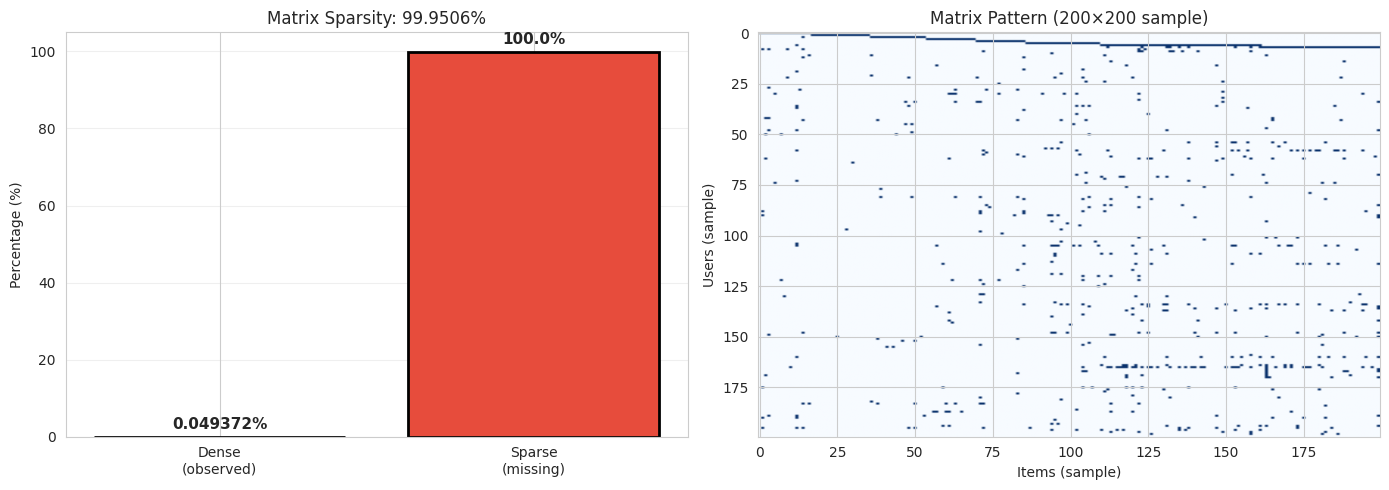


 Visualization saved: preprocessing_sparsity.png


In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Sparsity bar chart
axes[0].bar(['Dense\n(observed)', 'Sparse\n(missing)'],
           [density, 100-density],
           color=['#27ae60', '#e74c3c'],
           edgecolor='black', linewidth=2)
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title(f'Matrix Sparsity: {100-density:.4f}%')
axes[0].grid(True, alpha=0.3, axis='y')

# Add labels
for i, val in enumerate([density, 100-density]):
    label = f'{val:.6f}%' if val < 1 else f'{val:.1f}%'
    axes[0].text(i, val + 2, label, ha='center', fontsize=11, fontweight='bold')

# 2. Sample matrix pattern
sample_size = 200
matrix_sample = full_matrix[:sample_size, :sample_size].toarray()

axes[1].imshow(matrix_sample, cmap='Blues', aspect='auto')
axes[1].set_xlabel('Items (sample)')
axes[1].set_ylabel('Users (sample)')
axes[1].set_title(f'Matrix Pattern ({sample_size}×{sample_size} sample)')

plt.tight_layout()
plt.savefig('preprocessing_sparsity.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: preprocessing_sparsity.png")


# Step 10 : Build User-Item Lookup

In [45]:
# For each user, store which items they've seen
user_seen_items = {}

for user_idx in range(num_users):
    items = train_matrix[user_idx].indices
    if len(items) > 0:
        user_seen_items[user_idx] = set(items)

print(f"\n Lookup dictionary created for {len(user_seen_items):,} users")
print(f"\nExample - User 0 has interacted with {len(user_seen_items.get(0, []))} items")



 Lookup dictionary created for 52,643 users

Example - User 0 has interacted with 14 items


# Step 11 : Item Popularity

In [46]:
# Get top-20 popular items
item_popularity = np.array(full_matrix.sum(axis=0)).flatten()
popular_items = np.argsort(-item_popularity)[:20]

print(f"\n Top-10 popular items:")
for i in range(10):
    item_idx = popular_items[i]
    count = int(item_popularity[item_idx])
    print(f"  {i+1}. Item {id2item_raw[item_idx]}: {count} interactions")

print(f"\n For cold-start users")



 Top-10 popular items:
  1. Item 896: 1741 interactions
  2. Item 43756: 1389 interactions
  3. Item 7897: 1244 interactions
  4. Item 36454: 1156 interactions
  5. Item 36477: 1137 interactions
  6. Item 900: 1047 interactions
  7. Item 49144: 1010 interactions
  8. Item 5790: 981 interactions
  9. Item 48177: 927 interactions
  10. Item 1258: 920 interactions

 For cold-start users


# Step 12 : Save Preprocessed Data

In [47]:
import pickle
import os

os.makedirs('preprocessed', exist_ok=True)

# Save mappings
with open('preprocessed/user2id.pkl', 'wb') as f:
    pickle.dump(user2id, f)
with open('preprocessed/item2id.pkl', 'wb') as f:
    pickle.dump(item2id, f)
with open('preprocessed/id2user_raw.pkl', 'wb') as f:
    pickle.dump(id2user_raw, f)
with open('preprocessed/id2item_raw.pkl', 'wb') as f:
    pickle.dump(id2item_raw, f)
with open('preprocessed/user_seen_items.pkl', 'wb') as f:
    pickle.dump(user_seen_items, f)
with open('preprocessed/popular_items.pkl', 'wb') as f:
    pickle.dump(popular_items, f)

# Save matrices
sp.save_npz('preprocessed/train_matrix.npz', train_matrix)
sp.save_npz('preprocessed/val_matrix.npz', val_matrix)
sp.save_npz('preprocessed/full_matrix.npz', full_matrix)

# Save CSVs
train_df.to_csv('preprocessed/train.csv', index=False)
val_df.to_csv('preprocessed/val.csv', index=False)

print("\n Saved:")
print("  - 6 pickle files")
print("  - 3 sparse matrices")
print("  - 2 CSV files")
print("\n All saved to 'preprocessed/' folder")



 Saved:
  - 6 pickle files
  - 3 sparse matrices
  - 2 CSV files

 All saved to 'preprocessed/' folder
